# UpSet plots with PyKrev 

**UpSet Plots** are an effective way of visualising intersections of three or more sets. This is particularly useful when we want to compare high resolution mass spectrometry data between multiple samples on the basis of shared and unique formula assignments. An implementation of UpSet plots in Python is [UpSetPlot](https://pypi.org/project/UpSetPlot/) which you will need to install before performing the following analysis. This analysis was made with upsetplot version 0.6.1.

In [1]:
import os
import upsetplot #the upsetplot implementation in python we are using to make upset plots
import matplotlib.pyplot as plt
import pandas as pd
import pykrev as pk

Read in the example data using ```read_csv```. 

In [2]:
A = pk.read_csv('../example_data/example_A.csv', column_headers = True) 
B = pk.read_csv('../example_data/example_B.csv', column_headers = True)
C = pk.read_csv('../example_data/example_C.csv', column_headers = True)
msTupleDict = pk.msTupleDict()
msTupleDict['A'] = A
msTupleDict['B'] = B
msTupleDict['C'] = C

In the following code cell, we create an UpSet plot comparing the samples and visualise the intersection composition based on elemental class, oxygen count and double bond equivalence. It's possible to change the colour and sizing of the plot, hide subsets based on size or degree and change the orientation of the plot. For more information see the UpSetPlot library [documentation](https://upsetplot.readthedocs.io/en/stable/auto_examples/index.html). 

Text(0, 0.5, 'Double bond \nequivalent')

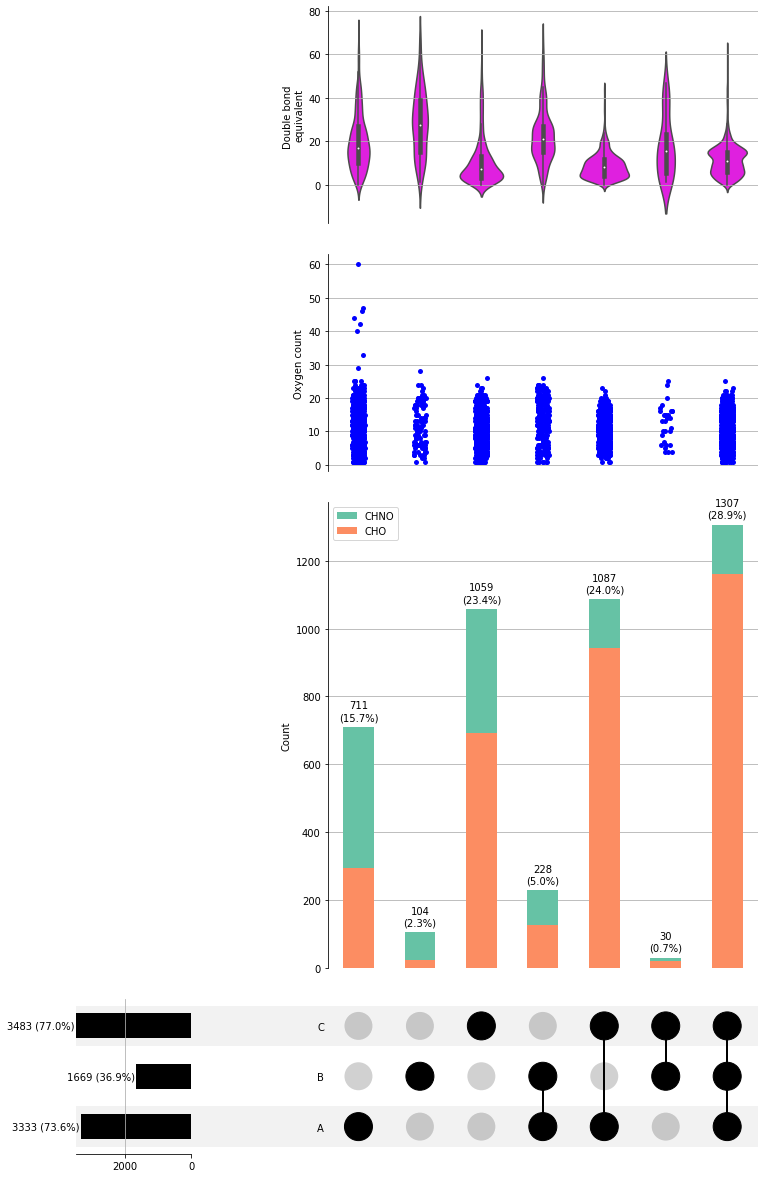

In [3]:
sample_dict = {'A':set(A.formula), 'B':set(B.formula), 'C':set(C.formula)} #we need to put the formula from our samples into a format that UpSet plot can parse.
sample_upset = upsetplot.from_contents(sample_dict) #create the series needed for the upsetplot using from_contents (this calculates the intersections automatically)

formula_to_analyse = sample_upset['id'] #a set of all the formula across all the samples
msTuple = pk.msTuple(formula_to_analyse, [], []) #transform the formula_to_analyse into an msTuple, we can ignore the intensity and mass values

counts = pk.element_counts(msTuple) #calculate the element counts for all the formula
o_number = [c['O'] for c in counts] #calculate the oxygen number for all the formula
dbe = pk.double_bond_equivalent(msTuple) #calculate the double bond equivalence for all the formula
compoundClass = pk.compound_class(msTuple, method= 'ELEM')[0] # calculate the elemental class for all the formula

#create a new dataframe including all the additional data    
data_add = pd.DataFrame({'dbe':dbe, 'compound class': compoundClass, 'Compound':formula_to_analyse, 'o number':o_number})
#index the dataframe by the molecular formula
data_add = data_add.set_index('Compound')

#reperform the intersection analysis including the additional data 
re_upset = upsetplot.from_contents(sample_dict,data=data_add)
#perform upset analysis on the resulting series
upset = upsetplot.UpSet(re_upset, show_counts=True, show_percentages = True, sort_categories_by = None,  intersection_plot_elements = 0, orientation='horizontal', element_size = 80)

# make the count bars correspond to elemental class
upset.add_stacked_bars(by="compound class", elements = 8, title = "Count", colors = 'Set2')
#add catplots corresponding to the calculated values, violin plots for distributions 
upset.add_catplot(value='o number', kind='strip', color='blue',elements = 4)
upset.add_catplot(value='dbe', kind='violin', color='magenta', ci = None, elements = 4)

#finally make the plot and save the returned handles 
upset_returns = upset.plot()

#relabel the cat plots using the returned handles
upset_returns['extra1'].set_ylabel('Oxygen count') # Y label
upset_returns['extra2'].set_ylabel('Double bond \nequivalent') # Y label

That's everything. Of course you don't have to include elemental class, oxygen counts or double bond equivalence, but whatever parameters are of interest.